In [1]:
# Import required libraries and dependencies
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data into a Pandas DataFrame
df_market_data = pd.read_csv(
    "Resources/crypto_market_data.csv",
    index_col="coin_id")

# Display sample data
df_market_data.head(5)

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384


In [3]:
# Generate summary statistics
df_market_data.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


In [4]:
df_market_data.shape

(41, 7)

In [5]:
# Plot your data to see what's in your DataFrame
df_market_data.hvplot.line(
    width=800,
    height=400,
    rot=90
)

:NdOverlay   [Variable]
   :Curve   [coin_id]   (value)

---

### Prepare the Data

In [6]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
crypto_market_scaled = StandardScaler().fit_transform(df_market_data[["price_change_percentage_24h", "price_change_percentage_7d", "price_change_percentage_14d","price_change_percentage_30d", "price_change_percentage_60d", "price_change_percentage_200d",  "price_change_percentage_1y"]])
                                                  


In [7]:
# Create a DataFrame with the scaled data
df_crypto_scaled = pd.DataFrame(crypto_market_scaled, columns = ["price_change_percentage_24h", "price_change_percentage_7d", "price_change_percentage_14d","price_change_percentage_30d", "price_change_percentage_60d", "price_change_percentage_200d",  "price_change_percentage_1y"])

# Copy the crypto names from the original data
df_crypto_scaled["coin_id"] = df_market_data.index
# Set the coinid column as index
df_crypto_scaled = df_crypto_scaled.set_index("coin_id")

# Display sample data
df_crypto_scaled.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317


---

### Find the Best Value for k Using the Original Data.

In [8]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1,11))

In [9]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    model = KMeans(n_clusters = i, random_state = 1)
    model.fit(df_crypto_scaled)
    inertia.append(model.inertia_)

  File "C:\Users\PC\anaconda3\envs\dev\lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\PC\anaconda3\envs\dev\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\PC\anaconda3\envs\dev\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\PC\anaconda3\envs\dev\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [10]:
# Create a dictionary with the data to plot the Elbow curve
elbow_crypto_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow_crypto = pd.DataFrame(elbow_crypto_data)

In [11]:
df_elbow_crypto

,k,inertia
0,1,287.000000
1,2,195.820218
2,3,123.190482
3,4,79.022435
4,5,63.858668
5,6,53.057788
6,7,44.406791
7,8,37.078233
8,9,32.832187
9,10,28.165433


In [12]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_plot_crypto = df_elbow_crypto.hvplot.line(x = "k", y="inertia", title = "Elbow Curve Using Crypto Data", xticks = k)
elbow_plot_crypto

:Curve   [k]   (inertia)

#### Answer the following question: 

**Question:** What is the best value for `k`?

**Answer: Based on the Elbow Curve, the best value for k looks like 4, i.e, K=4 .

---

### Cluster Cryptocurrencies with K-means Using the Original Data

In [13]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters = 4)

In [14]:
# Fit the K-Means model using the scaled data
model.fit(df_crypto_scaled)

KMeans(n_clusters=4)

In [15]:
# Predict the clusters to group the cryptocurrencies using the scaled data
crypto_clusters = model.predict(df_crypto_scaled)

# Print the resulting array of cluster values.
print(crypto_clusters)

[0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 2 0 1 1 3
 1 1 1 1]


In [16]:
# Create a copy of the DataFrame
df_crypto_predictions = df_crypto_scaled.copy()

In [17]:
# Add a new column to the DataFrame with the predicted clusters
df_crypto_predictions["CryptoClusters"] = crypto_clusters

# Display sample data
df_crypto_predictions.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,CryptoClusters
coin_id,,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637,0
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352,0
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061,1
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546,1
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317,0


In [55]:
# Create a scatter plot using hvPlot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.
scatter_plot = df_crypto_predictions.hvplot.scatter(
    x = "price_change_percentage_24h",
    y = "price_change_percentage_7d",
    by = "CryptoClusters",
    hover_cols=["coin_id"],
    cmap='Category10',  
    title='Crypto Price Change with Original Data'
)

# Render the plot
scatter_plot

:NdOverlay   [CryptoClusters]
   :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)

---

### Optimize Clusters with Principal Component Analysis.

In [37]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

In [38]:
# Use the PCA model with `fit_transform` to reduce to 
# three principal components.
crypto_pca = pca.fit_transform(df_crypto_scaled)
# View the first five rows of the DataFrame. 
crypto_pca[:5]

array([[-0.60066733,  0.84276006,  0.46159457],
       [-0.45826071,  0.45846566,  0.95287678],
       [-0.43306981, -0.16812638, -0.64175193],
       [-0.47183495, -0.22266008, -0.47905316],
       [-1.15779997,  2.04120919,  1.85971527]])

In [39]:
# Retrieve the explained variance to determine how much information 
# can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.3719856 , 0.34700813, 0.17603793])

#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** The total explained variance of the three principal components is 0.8950 which means that when we add together the explained variance ratios of the three principal components (37.20%, 34.70%, and 17.60%), we get a total of approximately 89.50%.It indicates that a significant portion of the variability in the dataset can be captured by these three principal components.

In [40]:
# Create a new DataFrame with the PCA data.
# Creating a DataFrame with the PCA data
crypto_pca_df = pd.DataFrame(crypto_pca, columns = ["PC1", "PC2", "PC3"])

# Copy the crypto names from the original data
crypto_pca_df["coin_id"] = df_crypto_scaled.index

# Set the coinid column as index
crypto_pca_df = crypto_pca_df.set_index("coin_id")

# Display sample data
crypto_pca_df.head()

,PC1,PC2,PC3
coin_id,,,
bitcoin,-0.600667,0.842760,0.461595
ethereum,-0.458261,0.458466,0.952877
tether,-0.433070,-0.168126,-0.641752
ripple,-0.471835,-0.222660,-0.479053
bitcoin-cash,-1.157800,2.041209,1.859715


---

### Find the Best Value for k Using the PCA Data

In [23]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1,11))

In [24]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_pca`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters = i, random_state = 1)
    k_model.fit(crypto_pca_df)
    inertia.append(k_model.inertia_)

In [25]:
# Create a dictionary with the data to plot the Elbow curve
elbow_crypto_pca = { "k" : k, "inertia": inertia}
# Create a DataFrame with the data to plot the Elbow curve
df_elbow_crypto_pca = pd.DataFrame(elbow_crypto_pca)

In [26]:
# Review the DataFrame
df_elbow_crypto_pca.head()

,k,inertia
0,1,268.707481
1,2,172.813447
2,3,98.899905
3,4,46.685148
4,5,35.918898


In [27]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
df_elbow_crypto_pca.hvplot.line(
    x = "k",
    y = "inertia",
    title = "Elbow Curve",
    xticks = k
)

:Curve   [k]   (inertia)

#### Answer the following questions: 

* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:** The best value for 'k' when using PCA data is 4.


* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** No I really didn't find any difference in finding the best k value with either original data or the PCA data.

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [41]:
crypto_pca_df.head()

,PC1,PC2,PC3
coin_id,,,
bitcoin,-0.600667,0.842760,0.461595
ethereum,-0.458261,0.458466,0.952877
tether,-0.433070,-0.168126,-0.641752
ripple,-0.471835,-0.222660,-0.479053
bitcoin-cash,-1.157800,2.041209,1.859715


In [47]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters = 4, random_state = 0)

In [48]:
# Fit the K-Means model using the PCA data
model.fit(crypto_pca_df)

KMeans(n_clusters=4, random_state=0)

In [49]:
# Predict the clusters to group the cryptocurrencies using the PCA data
crypto_four = model.predict(crypto_pca_df)

# Print the resulting array of cluster values.
crypto_four[:5]

array([2, 2, 0, 0, 2])

In [50]:
# Create a copy of the DataFrame with the PCA data
crypto_four_pca__predictions_df = crypto_pca_df.copy()

# Add a new column to the DataFrame with the predicted clusters
crypto_four_pca__predictions_df["Crypto Clusters"] = crypto_four

# Display sample data
crypto_four_pca__predictions_df.head()

,PC1,PC2,PC3,Crypto Clusters
coin_id,,,,
bitcoin,-0.600667,0.842760,0.461595,2
ethereum,-0.458261,0.458466,0.952877,2
tether,-0.433070,-0.168126,-0.641752,0
ripple,-0.471835,-0.222660,-0.479053,0
bitcoin-cash,-1.157800,2.041209,1.859715,2


In [57]:
# Create a scatter plot using hvPlot by setting 
# `x="PC1"` and `y="PC2"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.
crypto_four_pca__predictions_df.hvplot.scatter(
    x = "PC1",
    y = "PC2",
    by = "Crypto Clusters",
    hover_cols=["coin_id"],
    cmap='Category10',  
    title='Crypto Price Change with PCA data'
)

:NdOverlay   [Crypto Clusters]
   :Scatter   [PC1]   (PC2,coin_id)

### Visualize and Compare the Results

In this section, you will visually analyze the cluster analysis results by contrasting the outcome with and without using the optimization techniques.

In [58]:
#checking the original dataset
df_crypto_predictions.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,CryptoClusters
coin_id,,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637,0
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352,0
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061,1
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546,1
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317,0


In [63]:
#checking the PCA dataset
crypto_four_pca__predictions_df.head()

,PC1,PC2,PC3,Crypto Clusters
coin_id,,,,
bitcoin,-0.600667,0.842760,0.461595,2
ethereum,-0.458261,0.458466,0.952877,2
tether,-0.433070,-0.168126,-0.641752,0
ripple,-0.471835,-0.222660,-0.479053,0
bitcoin-cash,-1.157800,2.041209,1.859715,2


In [64]:
# Composite plot to contrast the Elbow curves
# Step 1: Compute distortion scores and plot elbow curves
def compute_distortion_scores(X, k_values):
    distortion_scores = []
    for k in k_values:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)
        distortion_scores.append(model.inertia_)
    return distortion_scores

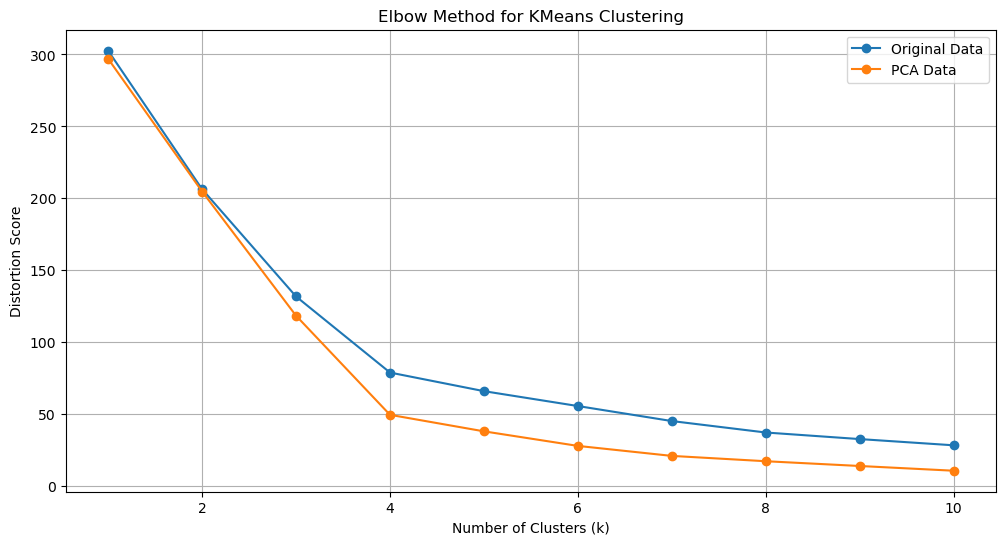

In [71]:
# Choose the range of k values for elbow method
k_values = range(1, 11)

# Compute distortion scores for both datasets
distortion_scores_original = compute_distortion_scores(df_crypto_predictions, k_values)
distortion_scores_pca = compute_distortion_scores(crypto_four_pca__predictions_df, k_values)

# Plot distortion scores
plt.figure(figsize=(12, 6))

# Plot for original data
plot_original = plt.plot(k_values, distortion_scores_original, marker='o', label='Original Data')

# Plot for PCA data
plot_pca = plt.plot(k_values, distortion_scores_pca, marker='o', label='PCA Data')

# Now, create the composite plot by using the plus(+) operator
composite_plot = plot_original + plot_pca

plt.title('Elbow Method for KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion Score')
plt.legend()
plt.grid(True)

# Display the composite plot
composite_plot

## Analysis

Here are the key observations from this plot:
- There are two lines on the plot, one for the original dataset (in blue) and one for the PCA-transformed data (in orange). 
- The y-axis represents the distortion score, which is a measure of the sum of the squared distances between each observation and the centroid of its cluster. Lower distortion scores indicate better clustering, as it means points are closer to their respective centroids.And the x-axis shows the number of clusters (k) that the KMeans algorithm is testing for. The plot shows values ranging from 1 to 10 clusters.
- For both lines, there is a point where the rate of decrease sharply changes, known as the "elbow.", the optimal number of clusters. In this plot, the elbow for the PCA data and original data, both seems to be at k=4, as beyond these points, adding more clusters does not significantly decrease the distortion score, indicating diminishing returns on the tightness of clusters.


In [66]:
# Composite plot to contrast the clusters
# Plot cryptocurrency clusters resulting from the original data
original_cluster_plot = df_crypto_predictions.hvplot.scatter(x='price_change_percentage_24h', 
                                                             y='price_change_percentage_7d', 
                                                             by='CryptoClusters', 
                                                             hover_cols=['coin_id'], 
                                                             title='Original Data Clusters')

# Plot cryptocurrency clusters resulting from the PCA data
pca_cluster_plot = crypto_four_pca__predictions_df.hvplot.scatter(x='PC1', y='PC2', 
                                                               by='Crypto Clusters', 
                                                               hover_cols=['coin_id'], 
                                                               title='PCA Data Clusters')

# Combine both plots
composite_plot = original_cluster_plot + pca_cluster_plot

# Show the composite plot
composite_plot

:Layout
   .NdOverlay.I  :NdOverlay   [CryptoClusters]
      :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)
   .NdOverlay.II :NdOverlay   [Crypto Clusters]
      :Scatter   [PC1]   (PC2,coin_id)

#### Answer the following question: 

  **Question: After visually analyzing the cluster analysis results, what is the impact of using fewer features to cluster the data using K-Means?**

Answer: We can make some inferences about the impact of using fewer features (via PCA) to cluster the data using K-Means:
  
i)Cluster Separation: The clusters in the original data are spread out, mostly along the x-axis (24-hour price change). Also, there is overlap between the clusters, suggesting that the features used may contain some amount of noise or irrelevant information that makes separation less distinct.
Whereas, Clusters in the PCA-transformed data appear to be more distinct, particularly along the first principal component (PC1). This suggests that PCA has extracted the most significant features that contribute to the variance and thus helps to define clearer boundaries between clusters.
 
ii) Cluster Density: In the original Data, clusters are less dense, with more scattered points, which may indicate that the features have not captured the underlying structure of the data as effectively.
 Whereas, in PCA Data, clusters seem tighter and more cohesive, indicating that the reduced features may be more relevant for the clustering task.
 
iii) Noise Reduction: As the chart displays, the PCA process helped to filter out noise by consolidating the variance into fewer dimensions, which can lead to a more robust clustering performance.

In conclusion, using fewer, more relevant features via PCA for K-Means clustering appears to have a positive impact on the clarity and quality of the resulting clusters. It seems to enhance cluster separation, density, and possibly the interpretability of the clustering solution. However, it's important to note that PCA is a linear dimensionality reduction technique and may not capture nonlinear relationships as effectively. The suitability of PCA should be considered in the context of the specific dataset and the clustering objectives.